In [1]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import pyepo
from pyepo.model.grb import optGrbModel
import torch
from torch import nn
from torch.utils.data import DataLoader
import time as time
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from ModelsKnapSack import KnapSackNet, ValPredictNet 

# Set the random seed
seed = 42
torch.manual_seed(seed)

Auto-Sklearn cannot be imported.


In [2]:
# generate data
num_data = 10000 # number of data
num_feat = 5 # size of feature
num_item = 100 # number of items
num_constraints = 2 # number of knapsacks
weights_numpy, contexts_numpy, costs_numpy = pyepo.data.knapsack.genData(num_data, num_feat, num_item,
                                                dim=num_constraints, deg=1, noise_width=0.5, seed=135)

In [3]:
device = 'mps'
weights = torch.Tensor(weights_numpy).to(device)
# print(weights)
## NB: Weights here refer to the weights of the items in the knapsack problem.
# They become part of the constraints.

In [4]:
capacities_numpy = 20*torch.ones(2)
capacities = capacities_numpy.to(device)
capacities_DYS = 18*torch.ones(2, device=device)
DYS_net = KnapSackNet(weights, capacities_DYS, num_constraints, num_item, num_feat, device=device)
DYS_net.to(device)

/Users/danielmckenzie/My-Drive/Research/Fixed_Point_Networks/Diff-Opt-Over-Polytopes-Project/SPO_with_DYS/Knapsack_Testing/dYS_opt_net.py:29: UserWarning: The operator 'aten::linalg_svd' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  U, s, VT = torch.linalg.svd(self.A, full_matrices=False)


KnapSackNet(
  (fc_1): Linear(in_features=5, out_features=50, bias=True)
  (fc_2): Linear(in_features=50, out_features=50, bias=True)
  (fc_3): Linear(in_features=50, out_features=100, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.1)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)

In [5]:
# ans = DYS_net(contexts)

In [6]:
# print(ans)

## 2. Setting up the Training


In [8]:
! pip show sklearn

In [9]:
# split train test data
from sklearn.model_selection import train_test_split
d_train, d_test, w_train, w_test = train_test_split(contexts_numpy, costs_numpy, test_size=100, random_state=42)

In [10]:
caps = capacities.cpu() #[20] * 2 # capacity
optmodel = pyepo.model.grb.knapsackModel(weights_numpy, caps)

Restricted license - for non-production use only - expires 2024-10-28


In [11]:
# get optDataset
dataset_train = pyepo.data.dataset.optDataset(optmodel, d_train, w_train)
dataset_test = pyepo.data.dataset.optDataset(optmodel, d_test, w_test)

Optimizing for optDataset...


 47%|█████████████████▊                    | 4631/9900 [00:19<00:20, 257.23it/s]


Interrupt request received


 53%|████████████████████▎                 | 5280/9900 [00:21<00:17, 259.77it/s]


Interrupt request received


100%|██████████████████████████████████████| 9900/9900 [00:41<00:00, 241.24it/s]


Optimizing for optDataset...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 233.29it/s]


In [9]:
# set data loader
from torch.utils.data import DataLoader
batch_size = 256
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

### Training Set-up
Hyperparameters, initialize optimizer, initialize arrays etc

In [10]:
test_loss_hist = []
fmt = '[{:4d}/{:4d}]: train loss = {:7.3e} | test_loss = {:7.3e} ]'
train_start_time = time.time()
epoch = 0
max_epochs = 10
train_loss_ave = 0

In [11]:
#### Testing Regret loss function
# Make eval mode that rounds before computing cost.
class RegretLoss(nn.Module):
    def __init__(self, num_item, num_constraints, device):
        super(RegretLoss, self).__init__()
        self.device = device
        self.num_items = num_item  # number of items, i.e. non-dummy variables
        self.num_constraints = num_constraints # number of constraints, i.e. dummy variables
    
    def forward(self, w_true, x_pred, x_opt, opt_value, eval_mode=False):
        '''
          d is (batch of) contexts, w_true is (batch of) true 
          cost vectors.
        '''
        if eval_mode:
            regret = opt_value - (w_true*torch.round(x_pred[:,:-(self.num_constraints + self.num_items)])).sum(dim=-1)
            regret = torch.mean(regret)/torch.mean(opt_value) #normalized regret
        else:
            regret = opt_value - (w_true*x_pred[:,:-(self.num_constraints + self.num_items)]).sum(dim=-1)
            regret = torch.mean(regret)
        return regret
    
    # cost = torch.matmul(w_true.view(-1, self.num_items), x_pred[:,:-self.num_constraints]) # leave out dummy variables

In [12]:
optimizer = optim.Adam(DYS_net.parameters(), lr=1e-3, weight_decay = 5e-4)
criterion = RegretLoss(num_item, num_constraints, device=device)
scheduler = ReduceLROnPlateau(optimizer, 'min')

In [13]:
epoch = 0
while epoch <= max_epochs:
    for d_batch, w_batch, opt_sol, opt_value in loader_train:
        d_batch = d_batch.to(device)
        w_batch = w_batch.to(device)
        opt_sol = opt_sol.to(device)
        opt_value = opt_value.to(device)
        DYS_net.train()
        optimizer.zero_grad()
        predicted = DYS_net(d_batch)
        loss = criterion(w_batch, predicted, opt_sol, opt_value)
        loss.backward()
        optimizer.step()
        train_loss_ave = 0.95*train_loss_ave + 0.05*loss.item()
        
    DYS_net.eval()
    test_loss = 0
    for d_batch, w_batch, opt_sol, opt_value in loader_test:
        d_batch = d_batch.to(device)
        w_batch = w_batch.to(device)
        opt_sol = opt_sol.to(device)
        opt_value = opt_value.to(device)
        predicted = DYS_net(d_batch)
        test_loss += max(0., criterion(w_batch, predicted, opt_sol, opt_value, eval_mode=True).item())
    
    # print(predicted)
    scheduler.step(test_loss)
    test_loss_hist.append(test_loss)
    print('epoch: ', epoch, 'test loss is ', test_loss)
    epoch += 1

epoch:  0 test loss is  0.9049567580223083
epoch:  1 test loss is  0.30895093083381653
epoch:  2 test loss is  0.2976419925689697
epoch:  3 test loss is  0.25240617990493774
epoch:  4 test loss is  0.25336864590644836
epoch:  5 test loss is  0.2569778561592102
epoch:  6 test loss is  0.2613089680671692
epoch:  7 test loss is  0.25240617990493774
epoch:  8 test loss is  0.2649182081222534
epoch:  9 test loss is  0.2666025161743164
epoch:  10 test loss is  0.2930702567100525


In [14]:
print((w_batch*torch.round(predicted[:,:-(num_item + num_constraints)])).sum(dim=-1))

tensor([29., 29., 26., 26., 58., 24., 34., 24., 38., 45., 31., 14., 33., 20.,
        18., 43., 25., 29., 22., 25., 27., 25., 26., 25., 28., 48., 40., 29.,
        61., 23., 30., 33., 35., 41., 30., 35., 43., 31., 25., 30., 21., 39.,
        29., 25., 20., 24., 30., 35., 24., 27., 28., 21., 37., 29., 22., 22.,
        24., 34., 23., 30., 15., 28., 24., 27., 22., 30., 42., 23., 31., 19.,
        29., 32., 33., 42., 26., 27., 32., 25., 35., 32., 22., 19., 29., 36.,
        34., 15., 32., 40., 25., 30., 29., 27., 31., 19., 43., 27., 33., 26.,
        22., 23.], device='mps:0')


In [16]:
print(opt_value)

tensor([[38.],
        [42.],
        [33.],
        [40.],
        [53.],
        [39.],
        [42.],
        [32.],
        [55.],
        [50.],
        [42.],
        [33.],
        [41.],
        [40.],
        [36.],
        [50.],
        [41.],
        [46.],
        [35.],
        [37.],
        [39.],
        [40.],
        [36.],
        [37.],
        [47.],
        [59.],
        [60.],
        [42.],
        [56.],
        [32.],
        [44.],
        [45.],
        [44.],
        [50.],
        [41.],
        [53.],
        [45.],
        [47.],
        [37.],
        [42.],
        [35.],
        [45.],
        [48.],
        [36.],
        [38.],
        [40.],
        [45.],
        [50.],
        [42.],
        [38.],
        [34.],
        [36.],
        [49.],
        [42.],
        [38.],
        [34.],
        [36.],
        [43.],
        [37.],
        [45.],
        [36.],
        [45.],
        [35.],
        [35.],
        [38.],
        [40.],
        [5

In [17]:
print(torch.matmul(weights, torch.t(torch.round(predicted[:,:-(num_item + num_constraints)]))))

tensor([[19.3500, 19.3500, 19.3500, 19.3500, 24.2200, 19.3500, 19.3500, 19.3500,
         14.4800, 19.3500, 19.3500, 19.3500, 19.3500, 19.3500, 19.3500, 19.3500,
         19.3500, 19.3500, 19.3500, 19.3500, 19.3500, 19.3500, 19.3500, 19.3500,
         19.3500, 19.3500, 14.4800, 19.3500, 24.2200, 19.3500, 19.3500, 19.3500,
         19.3500, 19.3500, 19.3500, 19.3500, 24.2200, 19.3500, 19.3500, 19.3500,
         19.3500, 19.3500, 19.3500, 19.3500, 19.3500, 19.3500, 19.3500, 19.3500,
         14.4800, 19.3500, 19.3500, 19.3500, 19.3500, 19.3500, 19.3500, 19.3500,
         19.3500, 19.3500, 19.3500, 19.3500, 19.3500, 19.3500, 19.3500, 19.3500,
         19.3500, 19.3500, 19.3500, 19.3500, 19.3500, 19.3500, 19.3500, 19.3500,
         19.3500, 19.3500, 19.3500, 19.3500, 19.3500, 19.3500, 19.3500, 19.3500,
         19.3500, 19.3500, 19.3500, 19.3500, 19.3500, 19.3500, 19.3500, 19.3500,
         19.3500, 19.3500, 19.3500, 19.3500, 19.3500, 19.3500, 19.3500, 19.3500,
         19.3500, 19.3500, 1

In [18]:
print(w_batch)

tensor([[5., 7., 6.,  ..., 7., 4., 8.],
        [4., 4., 8.,  ..., 5., 7., 8.],
        [4., 6., 4.,  ..., 4., 7., 8.],
        ...,
        [7., 3., 6.,  ..., 5., 5., 4.],
        [3., 5., 7.,  ..., 7., 6., 4.],
        [6., 6., 6.,  ..., 4., 6., 7.]], device='mps:0')


In [19]:
print(weights) # S matrix

tensor([[4.5900, 4.8700, 5.1900, 7.5900, 6.8000, 4.9700, 4.8400, 3.2200, 7.9000,
         3.6200, 3.1200, 6.8100, 7.0900, 3.2300, 4.4700, 5.2300, 6.1100, 5.2300,
         4.2700, 6.6600, 5.2100, 3.7200, 7.8300, 5.6400, 7.5600, 3.2800, 4.3100,
         3.8500, 6.4300, 4.2600, 7.5600, 6.4000, 6.0900, 6.4000, 4.5000, 6.3100,
         6.3500, 3.0700, 6.0300, 7.3900, 3.4800, 5.5700, 6.2700, 4.5500, 5.6400,
         5.6600, 3.2700, 6.6800, 4.2000, 5.6100, 6.1300, 7.8800, 4.6100, 4.9200,
         6.0900, 7.9500, 7.1100, 4.0200, 3.0700, 7.8400, 6.2900, 5.7800, 5.5700,
         5.6500, 7.4100, 5.2100, 3.4200, 6.4800, 5.7700, 7.6700, 7.3200, 3.3100,
         4.3600, 4.7500, 3.3800, 3.4400, 6.3000, 4.8500, 7.0900, 5.7000, 4.0500,
         6.0400, 6.5100, 3.4100, 7.9400, 6.0500, 7.1800, 3.6400, 4.3500, 4.4500,
         4.2700, 4.8700, 5.7400, 3.1600, 5.4100, 3.8100, 3.5100, 5.9800, 5.7900,
         6.6200],
        [5.1100, 3.1600, 7.0100, 6.4800, 6.3600, 4.1200, 7.9000, 7.6900, 3.6800,
         4

In [20]:
# print(torch.round(predicted[:,:-12]) - torch.round(predicted[0,:-12]))
print(torch.round((predicted[:,50:60])))#:-(num_constraints + num_item)])))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],


In [21]:
print(opt_sol[:15,:] - opt_sol[0,:])

tensor([[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0., -1.,  0.,  ...,  0.,  0.,  0.],
        [ 0., -1.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [ 0., -1.,  0.,  ...,  0.,  0.,  0.],
        [ 0., -1.,  0.,  ...,  0.,  0.,  0.],
        [ 0., -1.,  0.,  ...,  0.,  0.,  0.]], device='mps:0')


In [22]:
import matplotlib.pyplot as plt

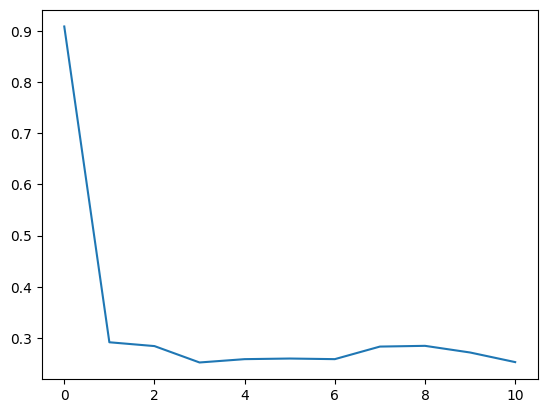

In [23]:
plt.plot(test_loss_hist)

In [24]:
print(DYS_net.s_inv)

tensor([0.0126, 0.0725, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071,
        0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071,
        0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071,
        0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071,
        0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071,
        0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071,
        0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071,
        0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071,
        0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071,
        0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071,
        0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071,
        0.7071, 1.0000, 1.0000], device='mps:0')


In [25]:
print(DYS_net.n2)

202


In [26]:
print(DYS_net.A)

tensor([[4.5900, 4.8700, 5.1900,  ..., 0.0000, 0.0000, 0.0000],
        [5.1100, 3.1600, 7.0100,  ..., 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000]],
       device='mps:0')


In [27]:
print(weights_numpy)

[[4.59 4.87 5.19 7.59 6.8  4.97 4.84 3.22 7.9  3.62 3.12 6.81 7.09 3.23
  4.47 5.23 6.11 5.23 4.27 6.66 5.21 3.72 7.83 5.64 7.56 3.28 4.31 3.85
  6.43 4.26 7.56 6.4  6.09 6.4  4.5  6.31 6.35 3.07 6.03 7.39 3.48 5.57
  6.27 4.55 5.64 5.66 3.27 6.68 4.2  5.61 6.13 7.88 4.61 4.92 6.09 7.95
  7.11 4.02 3.07 7.84 6.29 5.78 5.57 5.65 7.41 5.21 3.42 6.48 5.77 7.67
  7.32 3.31 4.36 4.75 3.38 3.44 6.3  4.85 7.09 5.7  4.05 6.04 6.51 3.41
  7.94 6.05 7.18 3.64 4.35 4.45 4.27 4.87 5.74 3.16 5.41 3.81 3.51 5.98
  5.79 6.62]
 [5.11 3.16 7.01 6.48 6.36 4.12 7.9  7.69 3.68 4.73 5.85 5.03 3.69 7.13
  7.11 5.72 5.8  4.59 6.85 4.14 6.18 4.28 5.38 5.79 6.78 3.79 4.61 3.06
  7.78 3.94 6.06 7.22 5.18 3.44 3.93 5.56 3.56 6.59 5.   5.24 7.94 6.75
  6.37 7.64 3.4  3.87 3.34 4.95 3.53 4.64 7.28 6.9  5.16 4.49 5.04 7.82
  7.41 6.92 7.45 7.29 6.31 6.6  4.66 4.07 7.25 5.58 5.33 7.82 7.37 6.23
  4.12 7.24 6.1  6.26 6.09 4.87 6.12 7.2  7.48 4.87 6.66 5.1  6.17 4.69
  4.41 4.04 6.   3.71 6.82 5.15 6.95 3.47 4.16 5.17

In [28]:
print(costs_numpy[0,:])

[3. 5. 7. 3. 8. 5. 5. 7. 4. 6. 6. 3. 3. 5. 7. 6. 7. 6. 4. 6. 5. 4. 6. 6.
 6. 4. 8. 7. 4. 6. 6. 7. 6. 5. 6. 6. 7. 8. 3. 6. 6. 6. 4. 5. 6. 3. 5. 6.
 8. 3. 4. 7. 7. 5. 4. 7. 4. 8. 8. 4. 5. 3. 5. 5. 6. 4. 9. 4. 6. 5. 6. 6.
 7. 7. 5. 7. 7. 4. 7. 7. 8. 6. 5. 7. 7. 9. 5. 5. 7. 5. 7. 7. 7. 6. 7. 8.
 6. 6. 5. 5.]


In [29]:
print(DYS_net.b)

tensor([18., 18.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.], device='mps:0')


In [30]:
torch.norm(weights)

tensor(80.3926, device='mps:0')

# 3. Preparing the benchmark approaches

In [31]:
optmodel = pyepo.model.grb.knapsackModel(weights_numpy, capacities_numpy)
val_net = ValPredictNet(num_constraints, num_item, num_feat, device=device)
val_net.to(device)
max_epochs = 10

In [32]:
## Train a two-stage approach
optimizer = optim.Adam(val_net.parameters(), lr=1e-2)
criterion = nn.MSELoss()
scheduler = ReduceLROnPlateau(optimizer, 'min')

In [33]:
epoch = 0
while epoch <= max_epochs:
    for d_batch, w_batch, opt_sol, opt_value in loader_train:
        d_batch = d_batch.to(device)
        w_batch = w_batch.to(device)
        opt_sol = opt_sol.to(device)
        opt_value = opt_value.to(device)
        val_net.train()
        optimizer.zero_grad()
        w_predicted = val_net(d_batch)
        loss = criterion(w_batch, w_predicted)
        loss.backward()
        optimizer.step()
        train_loss_ave = 0.95*train_loss_ave + 0.05*loss.item()
        
    val_net.eval()
    test_loss = 0
    for d_batch, w_batch, opt_sol, opt_value in loader_test:
        d_batch = d_batch.to(device)
        w_batch = w_batch.to(device)
        opt_sol = opt_sol.to(device)
        opt_value = opt_value.to(device)
        w_predicted = val_net(d_batch)
        test_loss += criterion(w_batch, w_predicted)
    
    # print(predicted)
    scheduler.step(test_loss)
    test_loss_hist.append(test_loss)
    print('epoch: ', epoch, 'test loss is ', test_loss.item())
    epoch += 1

epoch:  0 test loss is  6.611246109008789
epoch:  1 test loss is  3.933697462081909
epoch:  2 test loss is  3.5205788612365723
epoch:  3 test loss is  3.3509225845336914
epoch:  4 test loss is  3.2458724975585938
epoch:  5 test loss is  3.165217399597168
epoch:  6 test loss is  3.1080434322357178
epoch:  7 test loss is  3.0606706142425537
epoch:  8 test loss is  3.0264034271240234
epoch:  9 test loss is  2.99825119972229
epoch:  10 test loss is  2.9851582050323486


In [34]:
# compare solutions
for d_batch, w_batch, opt_sol, opt_value in loader_test:
    # load data
    # convert to numpy
    d_batch = d_batch.to(device)
    # d_batch = d_batch.to("cpu").detach().numpy()
    w_batch = w_batch.to("cpu").detach().numpy()
    opt_sol = opt_sol.to("cpu").detach().numpy()
    opt_value = opt_value.to("cpu").detach().numpy()
    # predict
    w_predicted = val_net(d_batch)
    # print(w_predicted)
    batch_size = d_batch.shape[0]
    regret = 0
    for i in range(batch_size):
        optmodel.setObj(w_predicted[i])
        pred_sol, pred_val = optmodel.solve()
        regret += np.max(np.squeeze(opt_value[i]) - np.dot(w_batch[i], pred_sol),0)
        # print((opt_value[i] - pred_val)/opt_value[i])
        print('Optimal value is ', opt_value[i], ' while predicted value is ', np.dot(w_batch[i], pred_sol))
#     if i == ind:
#         # solve
#         optmodel.setObj(cp[0])
#         wp, _ = optmodel.solve()
#         fig = plotSol(m, c, wp, weights, caps, "Two-Stage with Linear Regression")
#         break

    normalized_regret = regret/np.sum(opt_value)

Optimal value is  [38.]  while predicted value is  34.0
Optimal value is  [42.]  while predicted value is  37.0
Optimal value is  [33.]  while predicted value is  31.0
Optimal value is  [40.]  while predicted value is  26.0
Optimal value is  [53.]  while predicted value is  41.0
Optimal value is  [39.]  while predicted value is  31.0
Optimal value is  [42.]  while predicted value is  37.0
Optimal value is  [32.]  while predicted value is  21.0
Optimal value is  [55.]  while predicted value is  47.0
Optimal value is  [50.]  while predicted value is  48.0
Optimal value is  [42.]  while predicted value is  37.0
Optimal value is  [33.]  while predicted value is  25.0
Optimal value is  [41.]  while predicted value is  36.0
Optimal value is  [40.]  while predicted value is  31.0
Optimal value is  [36.]  while predicted value is  34.0
Optimal value is  [50.]  while predicted value is  44.0
Optimal value is  [41.]  while predicted value is  30.0
Optimal value is  [46.]  while predicted value i

In [35]:
print(normalized_regret)

0.17083734359961503


In [36]:
## SPO+ Loss
# initialize value-prediction network
device = 'cpu'
val_net2 = ValPredictNet(num_constraints, num_item, num_feat, device=device)
val_net2.to(device)
# set optimizer
optimizer = torch.optim.Adam(val_net2.parameters(), lr=1e-2)
# init SPO+ loss
criterion = pyepo.func.SPOPlus(optmodel, processes=1)


# # train model
# num_epochs = 20
# reg.train()
# for epoch in range(num_epochs):
#     # load data
#     for i, data in enumerate(loader_train):
#         x, c, w, z = data
#         # cudaa
#         if torch.cuda.is_available():
#             x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
#         # forward pass
#         cp = reg(x)
#         # spo+ loss
#         loss = spop(cp, c, w, z).mean()
#         # backward pass
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#     if epoch % 5 == 0:
#         # regret
#         regret = pyepo.metric.regret(reg, optmodel, loader_test)
#         print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%".format(epoch, loss.item(), regret*100))
# # regret
# regret = pyepo.metric.regret(reg, optmodel, loader_test)
# print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%".format(epoch, loss.item(), regret*100))

Num of cores: 1


In [37]:
# train model
epoch = 0
while epoch <= max_epochs:
    for d_batch, w_batch, opt_sol, opt_value in loader_train:
        d_batch = d_batch.to(device)
        w_batch = w_batch.to(device)
        opt_sol = opt_sol.to(device)
        opt_value = opt_value.to(device)
        val_net2.train()
        optimizer.zero_grad()
        w_predicted = val_net2(d_batch)
        loss = criterion(w_predicted, w_batch, opt_sol, opt_value).mean()
        loss.backward()
        optimizer.step()
        train_loss_ave = 0.95*train_loss_ave + 0.05*loss.item()
        
    val_net2.eval()
    test_loss = 0
    for d_batch, w_batch, opt_sol, opt_value in loader_test:
        d_batch = d_batch.to(device)
        w_batch = w_batch.to(device)
        opt_sol = opt_sol.to(device)
        opt_value = opt_value.to(device)
        w_predicted = val_net2(d_batch)
        #print(w_predicted[0])
        test_loss += criterion(w_predicted, w_batch, opt_sol, opt_value).mean()
    
    # print(predicted)
    #scheduler.step(test_loss)
    test_loss_hist.append(test_loss)
    print('epoch: ', epoch, 'test loss is ', test_loss.item())
    epoch += 1

epoch:  0 test loss is  21.098979949951172
epoch:  1 test loss is  19.743213653564453
epoch:  2 test loss is  19.175342559814453
epoch:  3 test loss is  18.501697540283203
epoch:  4 test loss is  18.271207809448242
epoch:  5 test loss is  18.415706634521484
epoch:  6 test loss is  18.457067489624023
epoch:  7 test loss is  18.404882431030273
epoch:  8 test loss is  18.315059661865234
epoch:  9 test loss is  18.289501190185547
epoch:  10 test loss is  18.100351333618164
